<center>
    
# **Layout Recognition** 

</center>

## **My approach**


### **Why YOLOv5 for Spanish Document Layout Detection?**  

I chose **YOLOv5** for detecting the layout of Spanish documents because of the following key reasons:  

1. **State-of-the-Art Object Detection**  
   - YOLOv5 is one of the leading models for real-time object detection, providing a balance of **speed and accuracy**.  
   - It is widely used in various domains, including document analysis.  

2. **Transfer Learning on Custom Data**  
   - Since YOLOv5 supports **transfer learning**, I can fine-tune it on a small labeled dataset of Spanish documents.  
   - This allows the model to adapt to unique layout patterns, such as **titles, paragraphs, and tables**.  

3. **Efficiency & Lightweight Architecture**  
   - YOLOv5 is optimized for fast inference, making it suitable for large-scale document processing.  
   - It supports **hardware acceleration**, leveraging **MPS on M2 Pro**, making it ideal for my setup(Sadly couldn't benefit much from this. More on it later).  

4. **Bounding Box Precision**  
   - The model’s **anchor-based detection** ensures accurate bounding boxes around **text regions, figures, and columns**.  
   - This is critical for **OCR preprocessing**, ensuring better text extraction.  

5. **Easy Integration & Training Pipeline**  
   - YOLOv5 has an easy-to-use training pipeline, with support for **COCO format annotations**, making dataset preparation straightforward.  
   - It provides built-in **augmentation techniques** that enhance generalization on diverse document layouts.  

By leveraging YOLOv5, I aim to create a **robust document layout analysis model** that can be used for further **OCR and text extraction tasks** in historical Spanish texts.
The steps followed are:

1. **General dataset selection and preparation**
2. **Specific dataset preparation**
3. **Train YOLOv5 on general dataset and analyze performance**
4. **Train YOLOv5 with our saved weights and evaluate performance**

### Download YOLOv5
```
git clone https://github.com/ultralytics/yolov5 # clone repository
cd yolov5
pip install -r requirements.txt # install dependencies
```
### 1. **General dataset selection and preparation**
For our training we use **yolov5n.pt** weights due to limited resource availability. 
Initial datatset: We pre-train our model on an openly available newspaper dataset as it resembles closely to recognising the layout of documents. This dataset is freely available on ultralytics website, and we can look at few examples of the same.

This dataset contains ~1200/~100 train/val images.

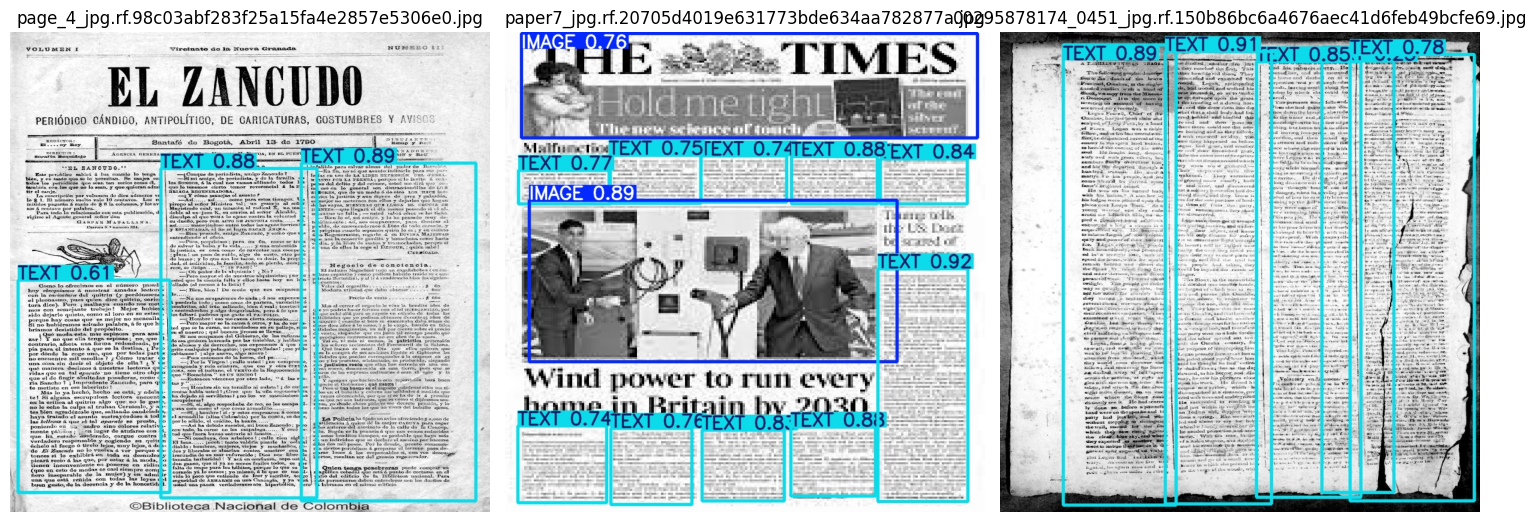

In [61]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
from PIL import Image

def display_images(folder_path: str, nimages = 3, axis = 0):

    # Get a list of image files
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))][:nimages]  # Select first 3 images
    
    # Plot images in a row
    if axis:
        fig, axes = plt.subplots(nimages, 1, figsize=(15, 15))
    else:
        fig, axes = plt.subplots(1, nimages, figsize=(15, 15))
    
    for ax, img_file in zip(axes, image_files):
        img = Image.open(os.path.join(folder_path, img_file))
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        ax.set_title(img_file)
    
    plt.tight_layout()
    plt.show()

# Display images in newspaper dataset:
display_images("./yolov5/runs/detect/exp12")

### 2. **Specific dataset preparation**
We now convert our given spanish documents for training into **YOLOv5 format**. This is trivial as the ultralytics UI makes it easier. We create bounding boxes and the UI creates a zip file for us to train on us. Let's look at some samples from the image here. 

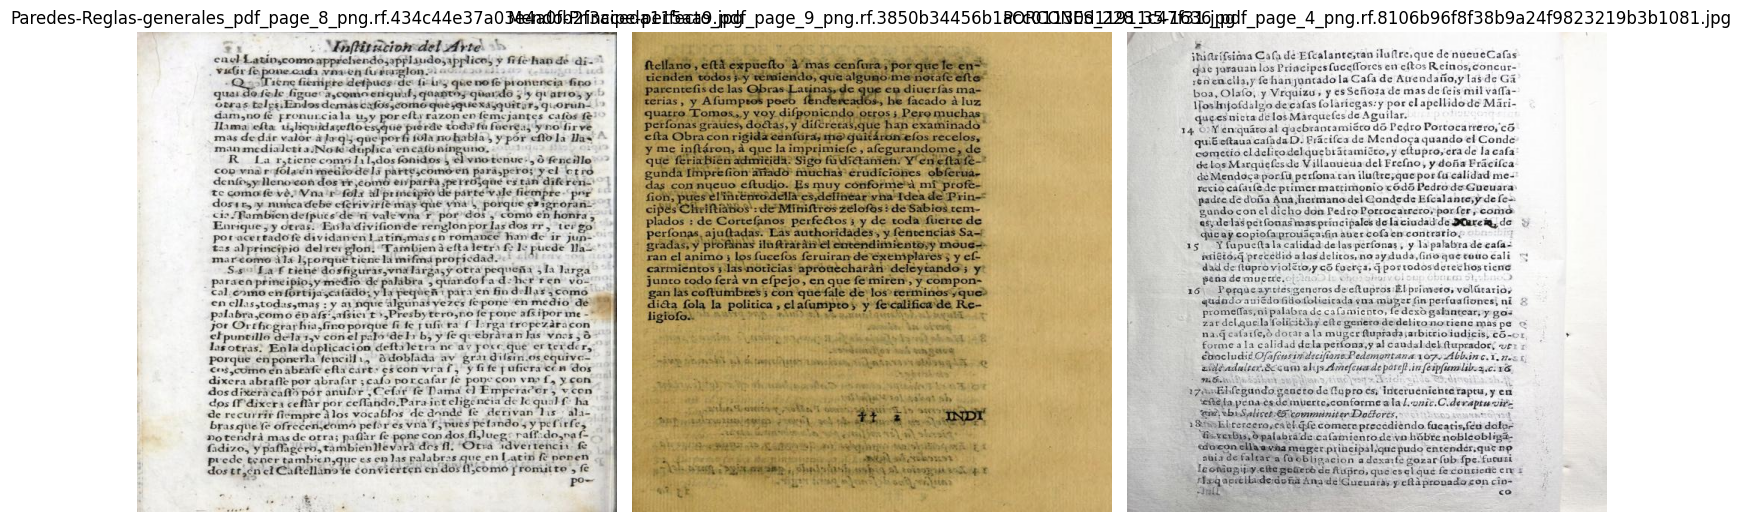

In [62]:
display_images("./yolov5/spanishdocs/train/images")

### 3. **Train YOLOv5 on general dataset and analyze performance**

We train for: 

- imgsz = 416
- batch size = 32
- epochs = 30
- workers = 2
- weights = yolov5n.pt

Now train using: 
```
python train.py --data ./newspaper_data/data.yaml --epochs 50  --imgsz 416 --weights yolov5n.pt --batch-size 32 --workers 2
```

Let's look at the metrics after training: 

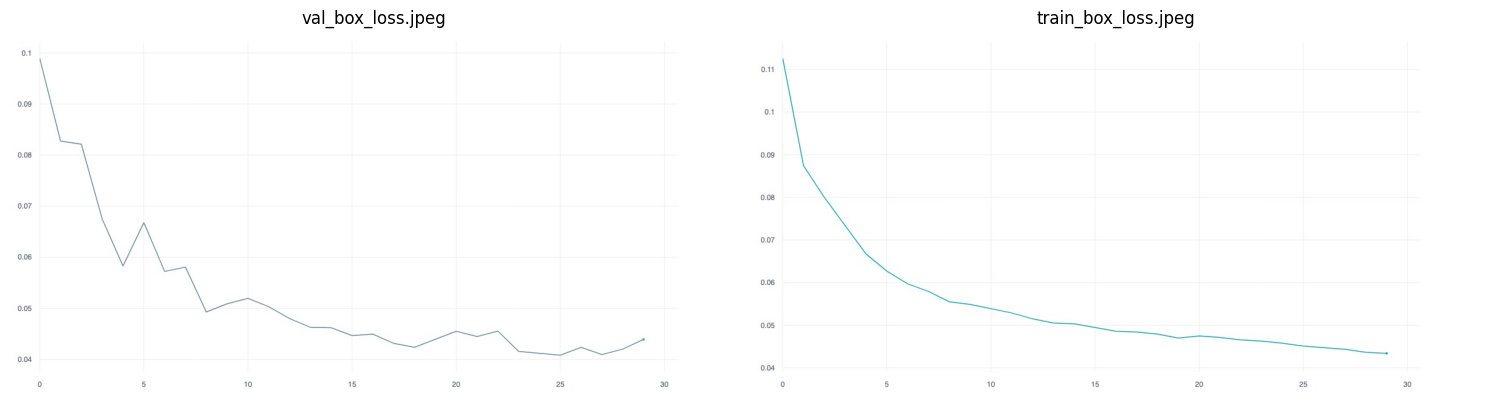

In [63]:
# Display the train/ val curves:
display_images("./newspapermetrics/trainValCurves", 2, 0)

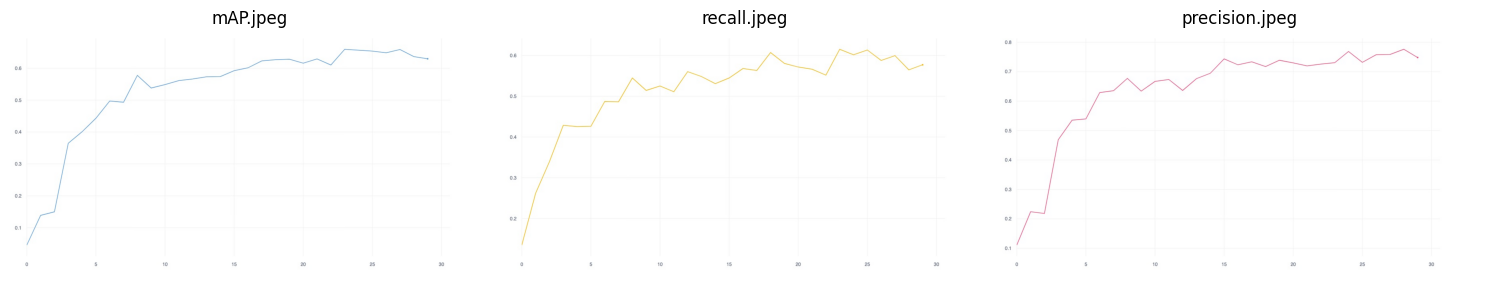

In [64]:
# Display the performace metrics curves:
display_images("./newspapermetrics", 3, 0)

Post training, we observe the following metrics: 

- Train/ val curves as expected, decreasing overall
- **mAP ~ 0.65**
- **Precision ~ 0.8**
- **Recall ~ 0.67**

## Limited Resources Bottleneck
I couldn't train my pre-trained model as well enough due to the following system resource limitations:
- I use M2 Pro, which has access to mps(Metal Performance Shards), and yolo currently has issues wth **memory leakages** as explained here. This was a clear bottleneck while training, as I checked with htop, where **system runs out of RAM**, uses disk swap disk space which slowed down training per iteration(multiply by no. of iterations per epoch and total epochs) by a **factor of 4x**. As a result, I had to shift training to only cpu which was still faster, but not fast enough.

**NOTE:** This is the reason we couldn't train longer on this dataset, but with better resources our performance on the newspaper dataset shall also improve. 

## 4. **Train YOLOv5 with our saved weights and evaluate performance**
Now let's train our model with the saved weights on our spanish document dataset for finetuning. We are using the concept of **transfer learning** here. To retrain use the following command: 
```
python train.py --data ./spanishdocs/data.yaml --epochs 50  --imgsz 416 --weights ./runs/train/exp41/weights/best.pt --batch-size 16 --workers 4 
```

Now let's evaluate new metrics: 

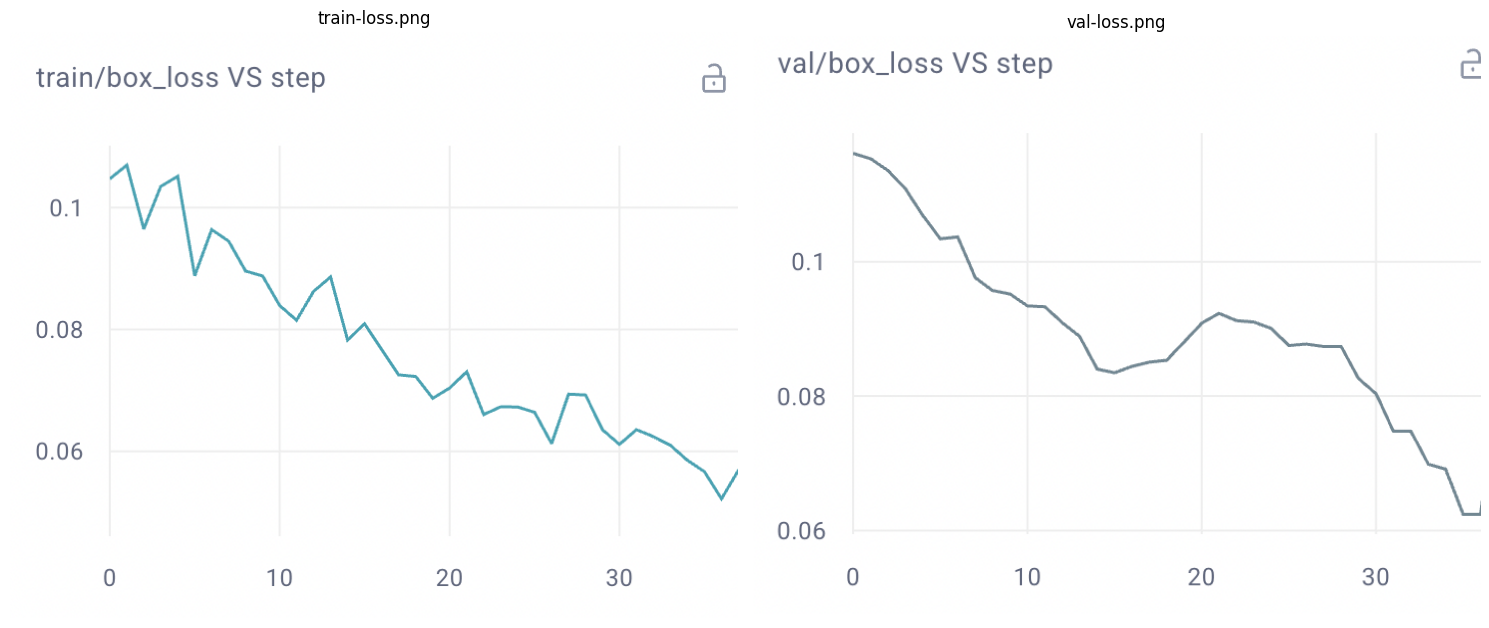

In [65]:
# Display the performace metrics curves for spanish docs:
display_images("./spanishdocs/trainValCurves", 2, 0)

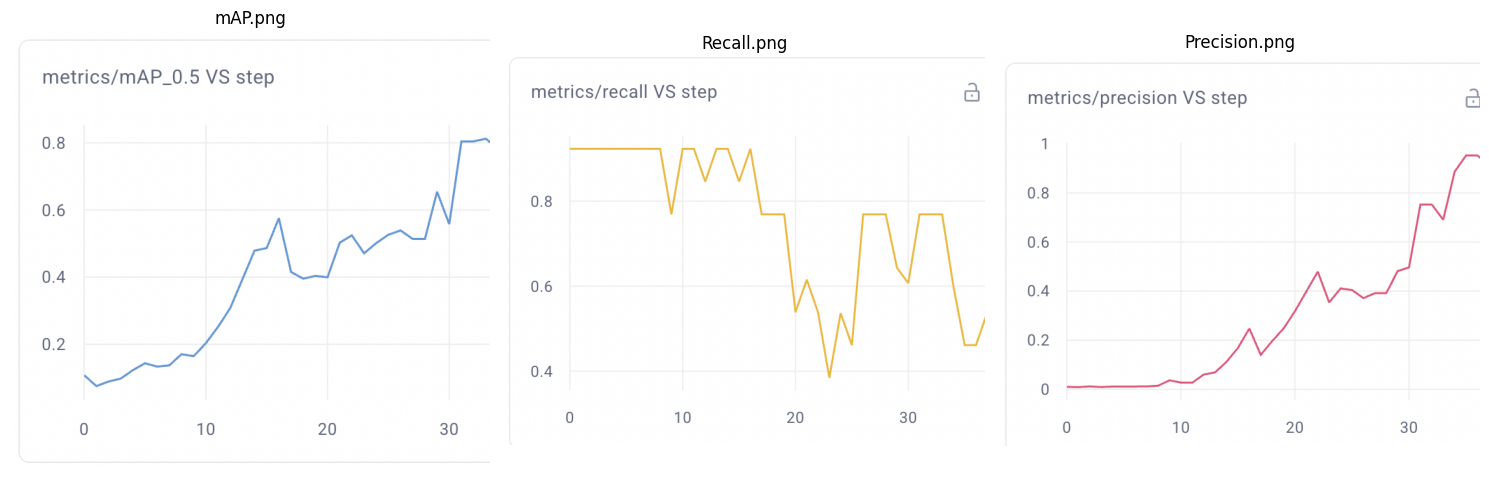

In [66]:
# Display the performace metrics curves for spanish docs:
display_images("./spanishdocs", 3, 0)

Post training, we observe the following metrics: 

- Train/ val curves as expected, decreasing overall
- **mAP ~ 0.8**
- **Precision ~ 1**
- **Recall ~ 0.8**

Let's now perform detection based on our new model weights, on our spanish dataset and visualize the performance. To run detect use: 
```
python detect.py --source ./spanishdocs/train/images  --imgsz 416 --weights ./runs/train/exp44/weights/best.pt
```



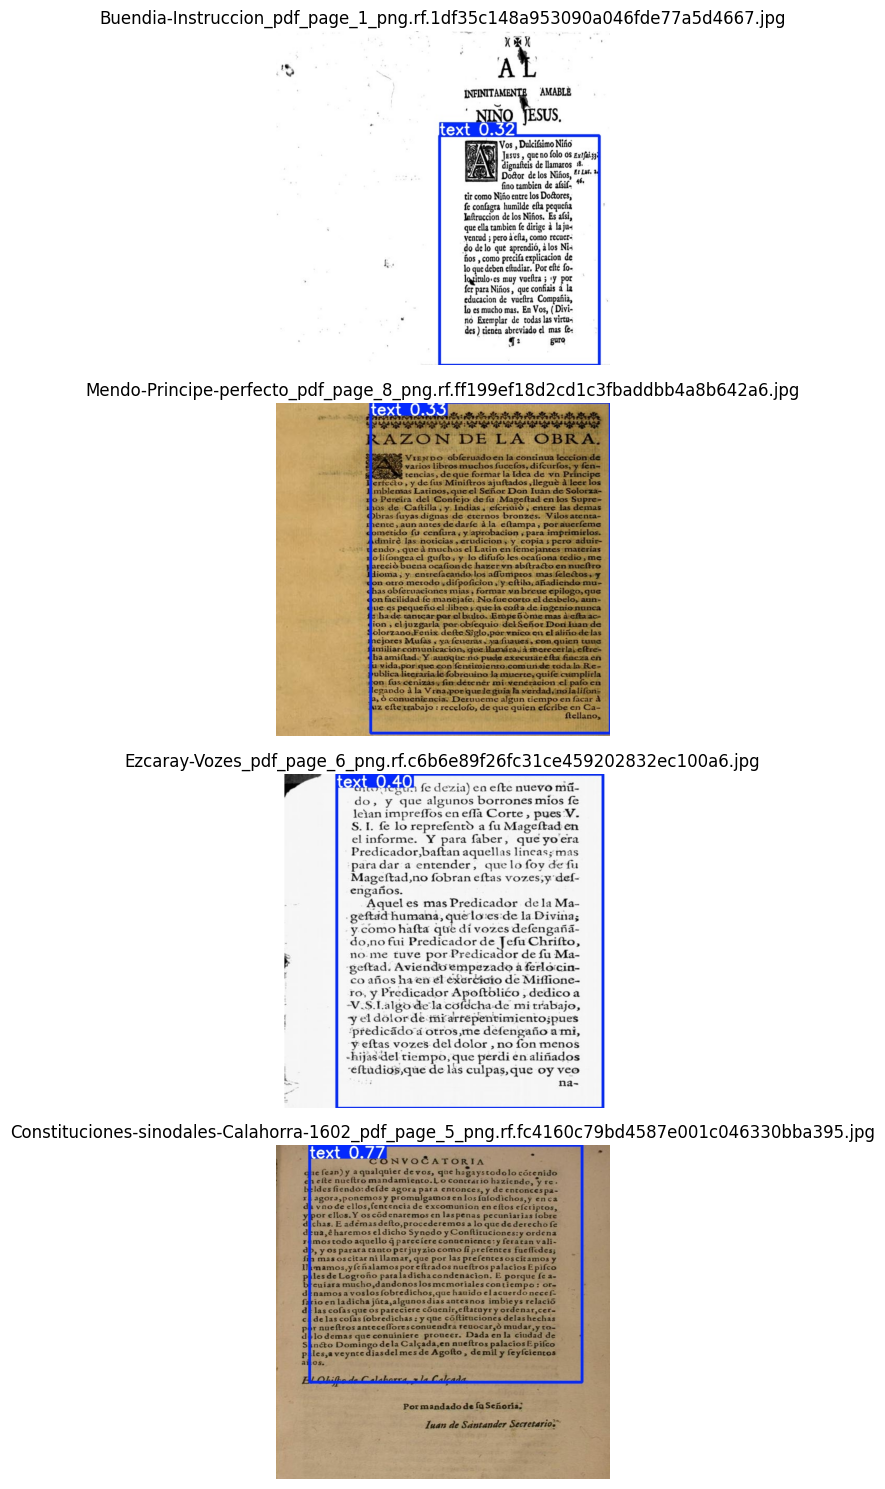

In [67]:
# Display detections performed:
display_images("./yolov5/runs/detect/exp18", 4, 1)

## Conclusion and Further Improvements
Based on the observed results, we are able to see that we achieved **mAP~0.8**, **P~1** and **R~0.8**. These are good indicators, that are model is performing well, however there are still some falso negatives. On closer, inspection these seems to be due to lighting issue and background cluttering. To further improve our models, we need to:

1. Preprocess spanish doc images(apply binarization, grayscale conversion, denoising etc)
2. Train pre-trained model longer with further availability of resources to achieve better mAP than 0.65
3. Access to more spanish docs and labelled data will improve the performance further.

Further metrics(f1 score, correlogram, ) can be accessed on comet website as the website stores all metrics, just reach out to me for the same. 